# YOLO8 Multitask Training - FracAtlas Dataset

In [9]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# /content/drive/MyDrive/fracatlas.v3i.yolov8.zip

Mounted at /content/drive/


In [10]:
!unzip -u "/content/drive/My Drive/dataset_augmented.zip" -d "/content/dataset_augmented"

Archive:  /content/drive/My Drive/dataset_augmented.zip


In [11]:
import yaml

with open('/content/dataset_augmented/data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['train'] = '/content/dataset_augmented/train/images'
data['val'] = '/content/dataset_augmented/valid/images'

with open('/content/dataset_augmented/data.yaml', 'w') as f:
    yaml.dump(data, f)

In [12]:
# Install ultralytics
!pip install ultralytics -q

In [13]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import os

In [14]:
# Load YOLOv8 model
model = YOLO('yolov8n.pt')  # Downloads automatically

# Check dataset
data_yaml = "/content/dataset_augmented/data.yaml"
print(f"📊 Using dataset: {data_yaml}")

📊 Using dataset: /content/dataset_augmented/data.yaml


In [15]:
# Hyperparameters
epochs = 30
batch_size = 16
imgsz = 640

print(f"⚙️ Training config:")
print(f"   Epochs: {epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Image size: {imgsz}")

⚙️ Training config:
   Epochs: 30
   Batch size: 16
   Image size: 640


In [16]:
# Train the model (multitask: detection + classification)
results = model.train(
    data=data_yaml,
    epochs=epochs,
    batch=batch_size,
    imgsz=imgsz,
    project="runs",
    name="detect/exp",
    save=True,
    plots=True
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_augmented/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

In [23]:
# Validate and get metrics
val_results = model.val()

print(f"\n✅ Training Results:")
print(f"📁 Best weights: runs/detect/exp2/weights/best.pt")
print(f"📊 mAP50: {val_results.box.map50:.4f}")
print(f"📊 mAP50-95: {val_results.box.map:.4f}")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 542.8±237.1 MB/s, size: 23.1 KB)
val: Scanning /content/dataset_augmented/valid/labels.cache... 789 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 789/789 1.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 6.0it/s 8.3s
                   all        789       1152      0.858      0.847       0.86      0.556
             fractured        132        172        0.7      0.465      0.487      0.189
                  hand        283        310      0.932      0.979      0.976      0.759
              hardware         23         29      0.837      0.759      0.833      0.497
                   hip         63         63      0.896      0.953       0.95      0.688
                   leg        454        526      0.974      0.983      0.987      0.797
              shoulder         4

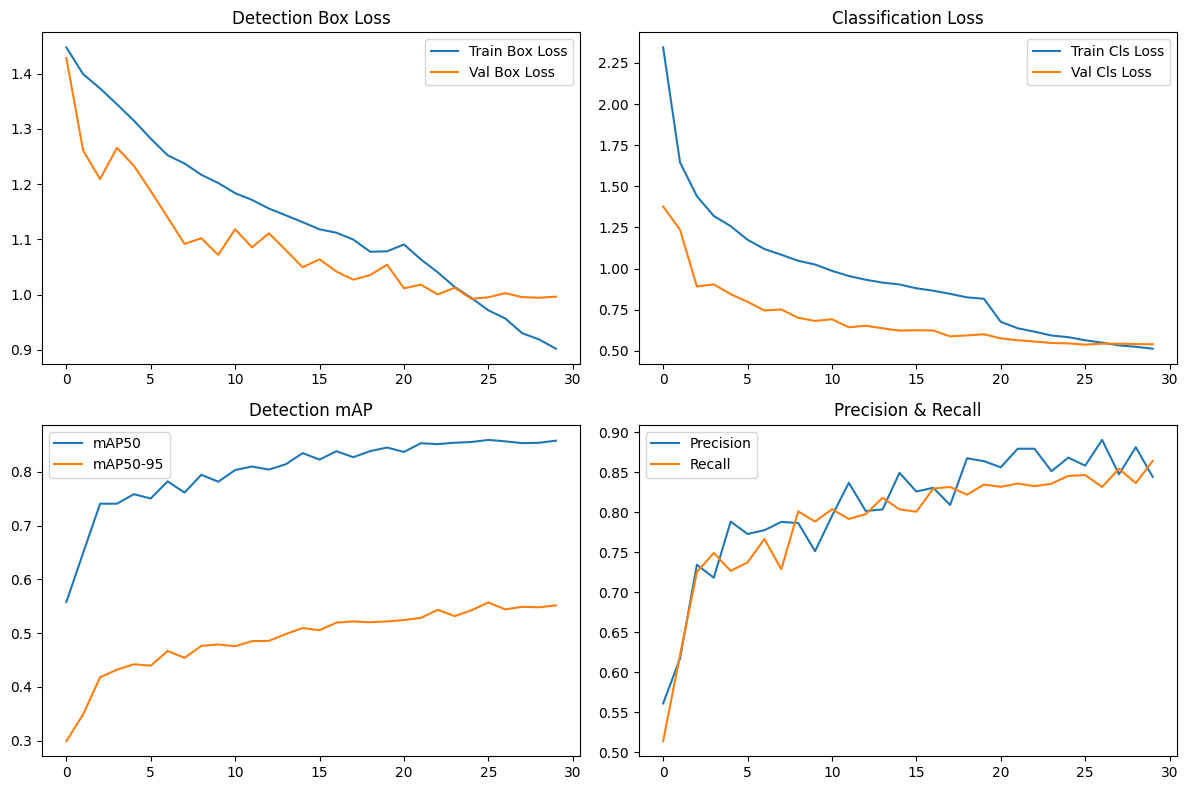

In [24]:
# Plot training curves
results_csv = "runs/detect/exp2/results.csv"
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Detection losses
    axes[0,0].plot(df['train/box_loss'], label='Train Box Loss')
    axes[0,0].plot(df['val/box_loss'], label='Val Box Loss')
    axes[0,0].set_title('Detection Box Loss')
    axes[0,0].legend()

    axes[0,1].plot(df['train/cls_loss'], label='Train Cls Loss')
    axes[0,1].plot(df['val/cls_loss'], label='Val Cls Loss')
    axes[0,1].set_title('Classification Loss')
    axes[0,1].legend()

    # mAP metrics
    axes[1,0].plot(df['metrics/mAP50(B)'], label='mAP50')
    axes[1,0].plot(df['metrics/mAP50-95(B)'], label='mAP50-95')
    axes[1,0].set_title('Detection mAP')
    axes[1,0].legend()

    # Precision/Recall
    axes[1,1].plot(df['metrics/precision(B)'], label='Precision')
    axes[1,1].plot(df['metrics/recall(B)'], label='Recall')
    axes[1,1].set_title('Precision & Recall')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()